#  🛠️ Feature Engineering for Stock Price Prediction
 
### This notebook demonstrates feature engineering using the existing `src/data.py` and new `src/features.py` modules.

### **Objectives:**
- Load stock data using existing data functions
- Create comprehensive technical features
- Validate feature quality and relationships
- Prepare features for modeling
 
### **Dependencies:**
- Uses existing `src/data.py` for data loading 
- Uses new `src/features.py` for feature creation

In [2]:
# Setup and Imports
import sys
import os
import json
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add project root to Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import from project modules (CORRECTED IMPORTS)
from src.data import (
    load_raw_data,
    clean_data,
    calculate_returns,
    validate_data_quality,
    get_trading_days,
    load_config,
    setup_logging
)

from src.features import (
    create_all_features,
    create_technical_indicators,
    create_price_features,
    create_volume_features,
    create_return_features,
    create_lag_features,
    create_rolling_features,
    validate_features,
    get_feature_importance_groups,
    get_feature_validation_report,
    process_stock_features
)

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Setup logging
logger = setup_logging()

print("All modules imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

2025-09-25 14:16:51 - data - INFO - Logging configuration initialized
All modules imported successfully!
Analysis Date: 2025-09-25 14:16:52


## 1: Load Stock Data

In [3]:
print("Loading stock data using existing data.py functions...")

# Define stocks to analyze
tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']
stock_data = {}

# Load data using EXISTING load_raw_data function
for ticker in tickers:
    try:
        filepath = f'../data/raw/{ticker}.csv'
        data = load_raw_data(filepath)
        
        # Validate data quality using existing function
        quality_check = validate_data_quality(data, detailed=True)
        
        if quality_check['overall']:
            stock_data[ticker] = data
            print(f"✓ {ticker}: {len(data)} rows loaded ({data.index.min().date()} to {data.index.max().date()})")
        else:
            print(f"⚠ {ticker}: Data quality issues detected: {quality_check['issues']}")
            
    except FileNotFoundError:
        print(f"✗ {ticker}: Data file not found - run data download first")
    except Exception as e:
        print(f"✗ {ticker}: Error loading data - {str(e)}")

print(f"\nSuccessfully loaded {len(stock_data)} stocks for feature engineering")


Loading stock data using existing data.py functions...
✓ AAPL: 1423 rows loaded (2020-01-02 to 2025-08-29)
✓ GOOGL: 1423 rows loaded (2020-01-02 to 2025-08-29)
✓ MSFT: 1423 rows loaded (2020-01-02 to 2025-08-29)
✓ TSLA: 1423 rows loaded (2020-01-02 to 2025-08-29)
✓ AMZN: 1423 rows loaded (2020-01-02 to 2025-08-29)

Successfully loaded 5 stocks for feature engineering


## 2: Basic Feature Creation - Technical Indicators

In [4]:
print("Creating technical indicators...")

# Use AAPL as example for detailed feature analysis
if 'AAPL' in stock_data:
    aapl_data = stock_data['AAPL'].copy()
    
    # Create technical indicators using features.py
    aapl_with_tech = create_technical_indicators(aapl_data)
    
    print(f"Original columns: {len(aapl_data.columns)}")
    print(f"With technical indicators: {len(aapl_with_tech.columns)}")
    print(f"New features added: {len(aapl_with_tech.columns) - len(aapl_data.columns)}")
    
    # Display some technical indicators
    tech_columns = [col for col in aapl_with_tech.columns if col not in aapl_data.columns]
    print(f"\nTechnical indicators created: {tech_columns[:10]}...")
    
    # Show sample data with technical indicators
    display_cols = ['Close', 'SMA_20', 'EMA_12', 'RSI_14', 'MACD', 'BB_Upper', 'BB_Lower']
    available_cols = [col for col in display_cols if col in aapl_with_tech.columns]
    print(f"\nSample technical indicators (last 5 days):")
    print(aapl_with_tech[available_cols].tail())

Creating technical indicators...
2025-09-25 14:16:52 - data - INFO - Technical indicators created.
Original columns: 6
With technical indicators: 27
New features added: 21

Technical indicators created: ['SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'EMA_12', 'EMA_26', 'RSI_14', 'MACD', 'MACD_Signal']...

Sample technical indicators (last 5 days):
                 Close      SMA_20      EMA_12     RSI_14      MACD  \
Date                                                                  
2025-08-25  227.160004  220.941353  226.009273  76.396983  4.944021   
2025-08-26  229.309998  221.855328  226.517076  71.347543  4.841103   
2025-08-27  230.490005  222.939177  227.128296  66.430828  4.799431   
2025-08-28  232.559998  224.200442  227.963943  56.844148  4.877216   
2025-08-29  232.139999  225.699912  228.606413  60.393979  4.849073   

              BB_Upper    BB_Lower  
Date                                
2025-08-25  243.441775  198.440931  
2025-08-26  244.144716  199.565939  


## 3: Price and Volume Features

In [5]:
print("Creating price and volume features...")

if 'AAPL' in stock_data:
    # Add price features
    aapl_with_price = create_price_features(aapl_with_tech)
    
    # Add volume features
    aapl_with_volume = create_volume_features(aapl_with_price)
    
    # Add return features
    aapl_with_returns = create_return_features(aapl_with_volume)
    
    print(f"After price features: {len(aapl_with_price.columns)} columns")
    print(f"After volume features: {len(aapl_with_volume.columns)} columns")
    print(f"After return features: {len(aapl_with_returns.columns)} columns")
    
    # Show new price/volume features
    price_vol_features = ['High_Low_Ratio', 'Daily_Range_Pct', 'Gap_Pct',
                         'Volume_Ratio_20', 'Returns_1d', 'Volatility_10d']
    available_features = [f for f in price_vol_features if f in aapl_with_returns.columns]
    
    print(f"\nSample price/volume features (last 5 days):")
    print(aapl_with_returns[available_features].tail())

Creating price and volume features...
2025-09-25 14:16:52 - data - INFO - Price features created.
2025-09-25 14:16:52 - data - INFO - Volume features created.
2025-09-25 14:16:52 - data - INFO - Return features created.
After price features: 34 columns
After volume features: 40 columns
After return features: 50 columns

Sample price/volume features (last 5 days):
            High_Low_Ratio  Daily_Range_Pct   Gap_Pct  Volume_Ratio_20  \
Date                                                                     
2025-08-25        1.013570         0.013515 -0.005620         0.502820   
2025-08-26        1.021363         0.020932 -0.001277         0.883423   
2025-08-27        1.011566         0.011454 -0.003053         0.511912   
2025-08-28        1.017747         0.017501  0.001432         0.646067   
2025-08-29        1.008687         0.008659 -0.000215         0.707917   

            Returns_1d  Volatility_10d  
Date                                    
2025-08-25   -0.002634        0.0

## 4: Lag and Rolling Features

In [6]:
print("Creating lag and rolling window features...")

if 'AAPL' in stock_data:
    # Create lag features
    aapl_with_lags = create_lag_features(
        aapl_with_returns,
        lags=[1, 2, 3, 5, 10],
        columns=['Close', 'Volume', 'Returns_1d']
    )
    
    # Create rolling features
    aapl_final = create_rolling_features(
        aapl_with_lags,
        windows=[5, 10, 20],
        columns=['Close', 'Volume'],
        statistics=['mean', 'std', 'min', 'max']
    )
    
    print(f"After lag features: {len(aapl_with_lags.columns)} columns")
    print(f"Final feature count: {len(aapl_final.columns)} columns")
    
    # Show lag features
    lag_features = [col for col in aapl_final.columns if 'lag_' in col]
    print(f"\nLag features created: {lag_features[:8]}...")
    
    # Show rolling features
    rolling_features = [col for col in aapl_final.columns if 'rolling_' in col]
    print(f"\nRolling features created: {rolling_features[:8]}...")

Creating lag and rolling window features...
2025-09-25 14:16:52 - data - INFO - Lag features created for lags: [1, 2, 3, 5, 10]
2025-09-25 14:16:52 - data - INFO - Rolling features created for windows: [5, 10, 20]
After lag features: 65 columns
Final feature count: 89 columns

Lag features created: ['Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_5', 'Close_lag_10', 'Volume_lag_1', 'Volume_lag_2', 'Volume_lag_3']...

Rolling features created: ['Close_rolling_5_mean', 'Close_rolling_5_std', 'Close_rolling_5_min', 'Close_rolling_5_max', 'Close_rolling_10_mean', 'Close_rolling_10_std', 'Close_rolling_10_min', 'Close_rolling_10_max']...


## 5: Create Complete Feature Sets

In [7]:
print("Creating complete feature sets for all stocks...")

# Create complete feature sets using the all-in-one function
complete_features = {}

for ticker in stock_data.keys():
    print(f"Processing {ticker}...")
    
    # Use the comprehensive feature creation function
    features_df = create_all_features(
        stock_data[ticker],
        include_technical=True,
        include_lags=True,
        include_rolling=True,
        lag_periods=[1, 2, 3, 5],
        rolling_windows=[5, 10, 20]
    )
    
    # Add ticker identification
    features_df['Ticker'] = ticker
    complete_features[ticker] = features_df
    
    print(f"  ✓ {ticker}: {len(features_df.columns)} features created")

print(f"\nFeature engineering completed for {len(complete_features)} stocks")


Creating complete feature sets for all stocks...
Processing AAPL...
2025-09-25 14:16:52 - data - INFO - Technical indicators created.
2025-09-25 14:16:52 - data - INFO - Price features created.
2025-09-25 14:16:52 - data - INFO - Volume features created.
2025-09-25 14:16:52 - data - INFO - Return features created.
2025-09-25 14:16:52 - data - INFO - Lag features created for lags: [1, 2, 3, 5]
2025-09-25 14:16:52 - data - INFO - Rolling features created for windows: [5, 10, 20]
2025-09-25 14:16:52 - data - INFO - All features created.
  ✓ AAPL: 83 features created
Processing GOOGL...
2025-09-25 14:16:52 - data - INFO - Technical indicators created.
2025-09-25 14:16:52 - data - INFO - Price features created.
2025-09-25 14:16:52 - data - INFO - Volume features created.
2025-09-25 14:16:52 - data - INFO - Return features created.
2025-09-25 14:16:52 - data - INFO - Lag features created for lags: [1, 2, 3, 5]
2025-09-25 14:16:52 - data - INFO - Rolling features created for windows: [5, 10, 

## 6: Feature Validation

In [8]:
print("Validating feature quality...")

# Custom validation function since validate_features only returns bool
def detailed_feature_validation(df):
    """Perform detailed feature validation analysis."""
    validation_report = {
        'total_features': len(df.columns),
        'total_rows': len(df),
        'missing_values': df.isnull().sum().to_dict(),
        'infinite_values': {},
        'constant_features': [],
        'high_correlation_pairs': []
    }
    
    # Check for infinite values in numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        inf_count = np.isinf(df[col]).sum()
        if inf_count > 0:
            validation_report['infinite_values'][col] = int(inf_count)
    
    # Check for constant features
    for col in numeric_cols:
        if df[col].nunique() <= 1:
            validation_report['constant_features'].append(col)
    
    # Basic validation using existing function
    validation_report['is_valid'] = validate_features(df)
    
    return validation_report

validation_reports = {}

for ticker, features_df in complete_features.items():
    print(f"\nValidating features for {ticker}:")
    
    # Use custom validation function
    report = get_feature_validation_report(features_df)
    validation_reports[ticker] = report
    
    print(f"  • Total features: {report['total_features']}")
    print(f"  • Total rows: {report['total_rows']}")
    print(f"  • Clean rows: {report['clean_rows']}")
    print(f"  • Data retention: {report['data_retention']:.1%}")
    print(f"  • Overall validation: {'PASS' if report['validation_passed'] else 'FAIL'}")
    
    # Show problematic features if any
    if report['infinite_values']:
        print(f"  ⚠ Infinite values in: {list(report['infinite_values'].keys())}")
    
    if report['constant_features']:
        print(f"  ⚠ Constant features: {report['constant_features']}")

Validating feature quality...

Validating features for AAPL:
2025-09-25 14:16:53 - data - INFO - --- Starting Feature Validation ---
2025-09-25 14:16:53 - data - INFO - ✅ Expected NaN pattern detected (0.77% of data)
2025-09-25 14:16:53 - data - INFO - NaN values from rolling windows: 909
2025-09-25 14:16:53 - data - INFO - ✅ No infinite values found.
2025-09-25 14:16:53 - data - INFO - --- Feature validation successful ---
2025-09-25 14:16:53 - data - INFO - Dataset shape: (1423, 83)
2025-09-25 14:16:53 - data - INFO - Clean rows available: 1224
  • Total features: 83
  • Total rows: 1423
  • Clean rows: 1224
  • Data retention: 86.0%
  • Overall validation: PASS

Validating features for GOOGL:
2025-09-25 14:16:53 - data - INFO - --- Starting Feature Validation ---
2025-09-25 14:16:53 - data - INFO - ✅ Expected NaN pattern detected (0.77% of data)
2025-09-25 14:16:53 - data - INFO - NaN values from rolling windows: 909
2025-09-25 14:16:53 - data - INFO - ✅ No infinite values found.
20

## 7: Feature Group Analysis

In [9]:
print("Analyzing feature groups...")

# Get predefined feature groups
if 'AAPL' in complete_features:
    aapl_features = complete_features['AAPL']
    feature_groups = get_feature_importance_groups(aapl_features)
    
    print("Feature groups defined:")
    for group_name, features in feature_groups.items():
        print(f"  • {group_name}: {len(features)} features")
    
    # Analyze feature availability
    available_features = set(aapl_features.columns)
    
    print(f"\nFeature availability analysis (AAPL example):")
    for group_name, group_features in feature_groups.items():
        available_in_group = [f for f in group_features if f in available_features]
        coverage = len(available_in_group) / len(group_features) * 100 if group_features else 0
        print(f"  • {group_name}: {len(available_in_group)}/{len(group_features)} features ({coverage:.1f}% coverage)")


Analyzing feature groups...
Feature groups defined:
  • SMA: 5 features
  • EMA: 2 features
  • RSI: 1 features
  • MACD: 3 features
  • BB: 4 features
  • Lag: 8 features
  • Rolling: 24 features
  • Return: 10 features
  • Volume: 25 features
  • Price: 5 features

Feature availability analysis (AAPL example):
  • SMA: 5/5 features (100.0% coverage)
  • EMA: 2/2 features (100.0% coverage)
  • RSI: 1/1 features (100.0% coverage)
  • MACD: 3/3 features (100.0% coverage)
  • BB: 4/4 features (100.0% coverage)
  • Lag: 8/8 features (100.0% coverage)
  • Rolling: 24/24 features (100.0% coverage)
  • Return: 10/10 features (100.0% coverage)
  • Volume: 25/25 features (100.0% coverage)
  • Price: 5/5 features (100.0% coverage)


## 8: Technical Indicators Visualization

Visualizing technical indicators...


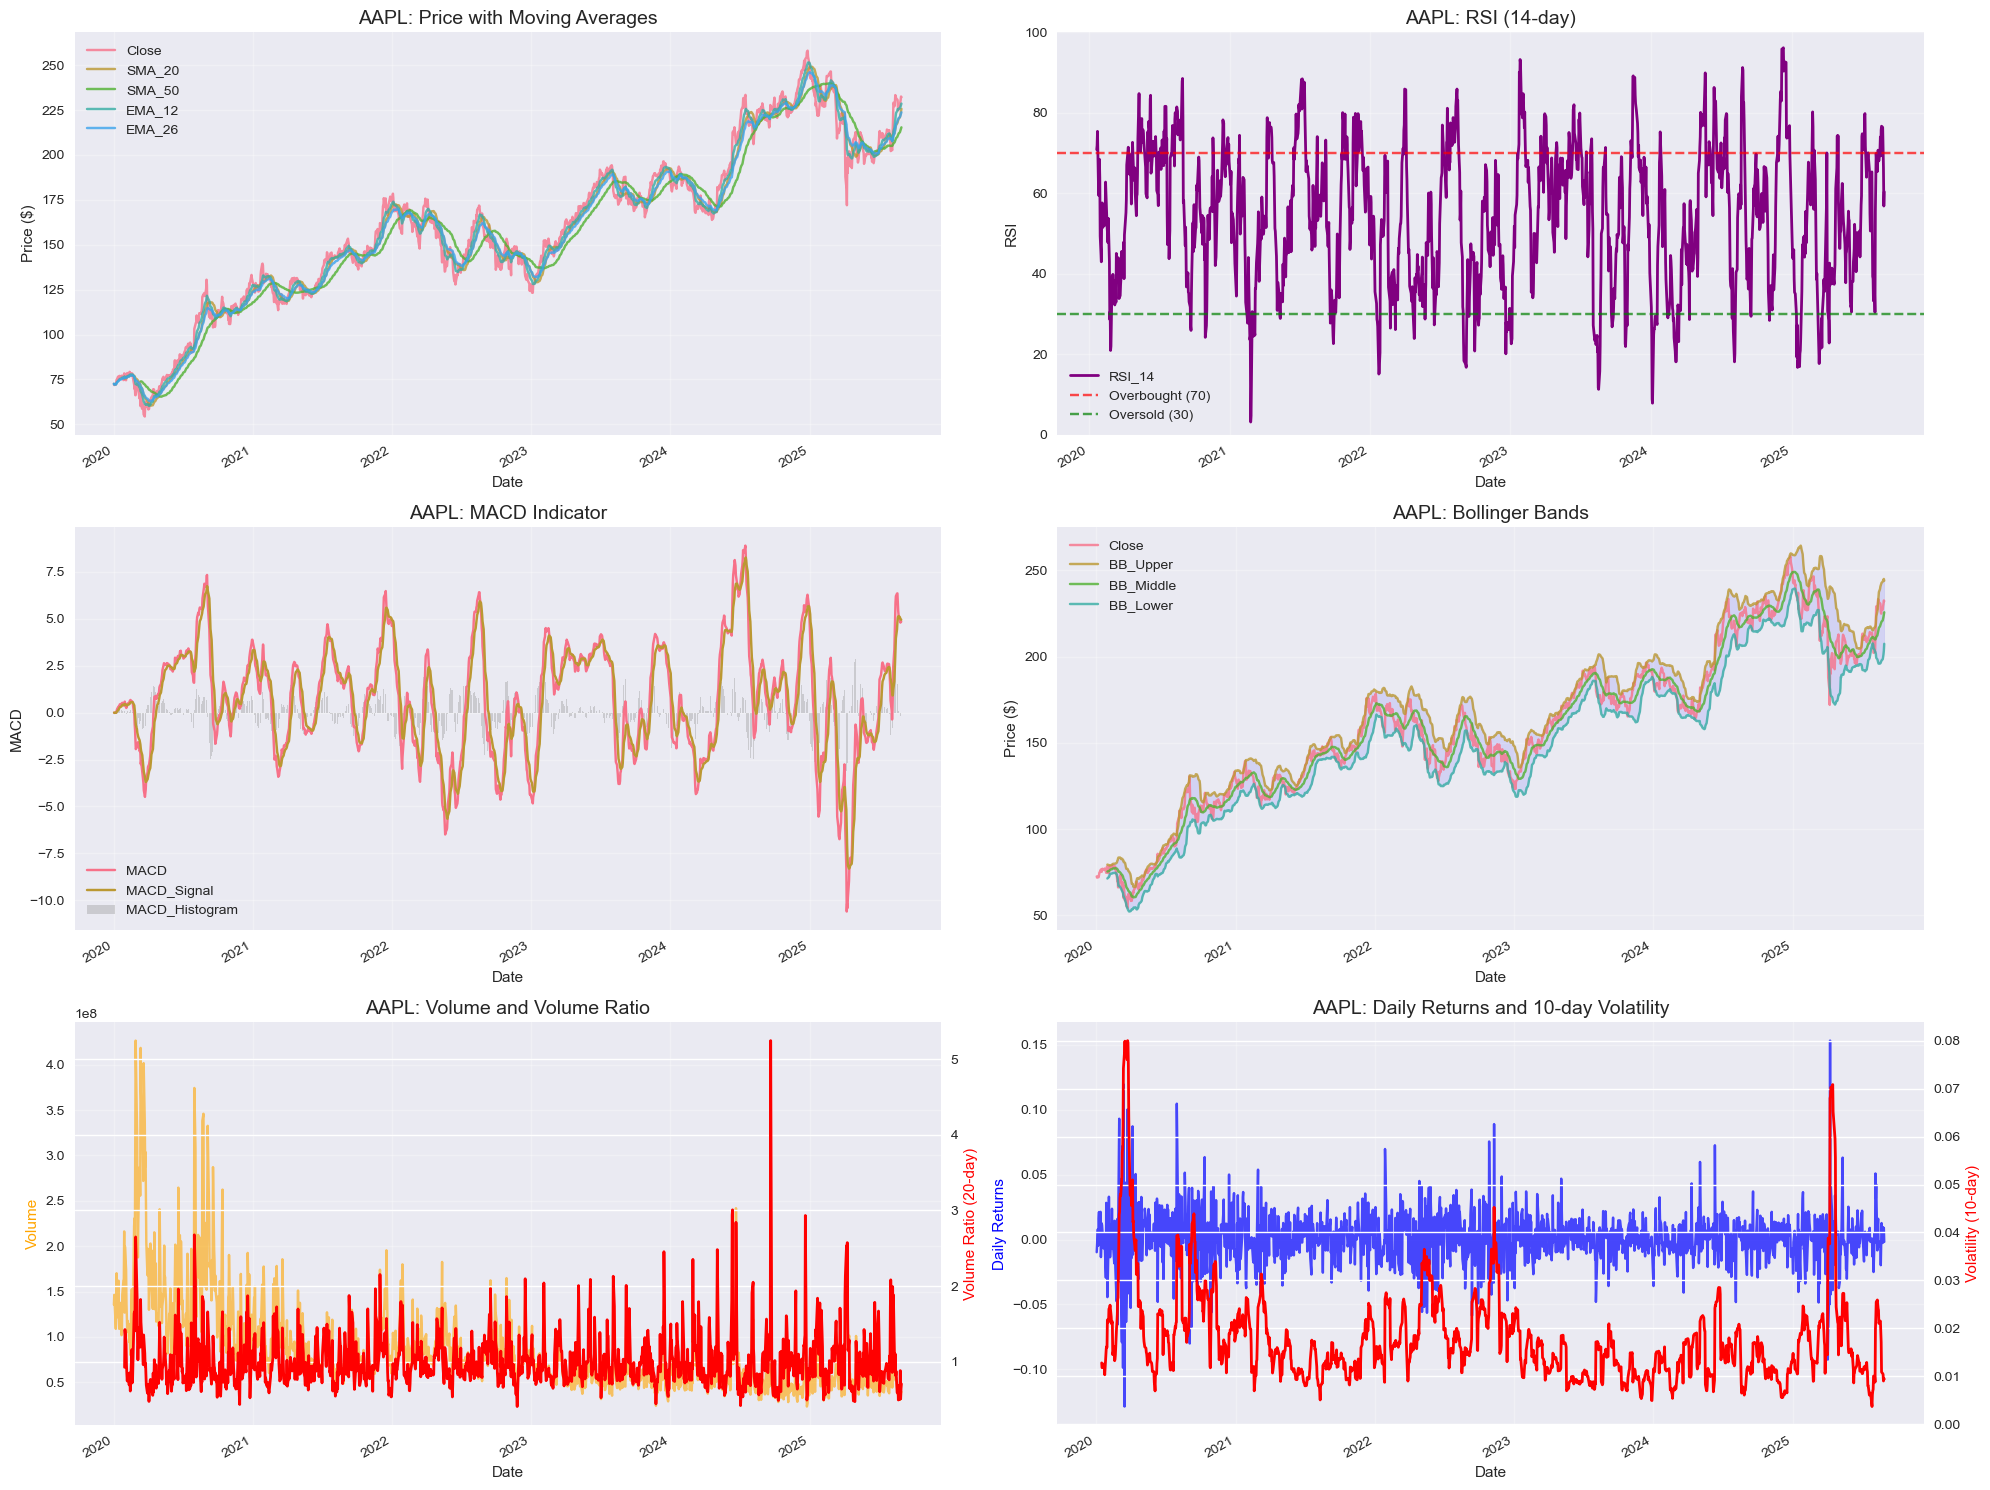

In [10]:
print("Visualizing technical indicators...")

if 'AAPL' in complete_features:
    aapl_features = complete_features['AAPL']
    
    # Create comprehensive technical analysis plot
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    
    # Price with moving averages
    ax1 = axes[0, 0]
    price_cols = ['Close', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26']
    available_price_cols = [col for col in price_cols if col in aapl_features.columns]
    aapl_features[available_price_cols].plot(ax=ax1, alpha=0.8)
    ax1.set_title('AAPL: Price with Moving Averages', fontsize=14)
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    
    # RSI
    ax2 = axes[0, 1]
    if 'RSI_14' in aapl_features.columns:
        aapl_features['RSI_14'].plot(ax=ax2, color='purple', linewidth=2)
        ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
        ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
        ax2.set_ylim(0, 100)
        ax2.legend()
    ax2.set_title('AAPL: RSI (14-day)', fontsize=14)
    ax2.set_ylabel('RSI')
    ax2.grid(True, alpha=0.3)
    
    # MACD
    ax3 = axes[1, 0]
    macd_cols = ['MACD', 'MACD_Signal']
    available_macd = [col for col in macd_cols if col in aapl_features.columns]
    if available_macd:
        aapl_features[available_macd].plot(ax=ax3)
    if 'MACD_Histogram' in aapl_features.columns:
        ax3.bar(
            aapl_features.index,
            aapl_features['MACD_Histogram'],
            color='gray',
            alpha=0.3,
            width=1,   # adjust width to make bars clear
            label='MACD_Histogram'
        )
    ax3.set_title('AAPL: MACD Indicator', fontsize=14)
    ax3.set_ylabel('MACD')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # Bollinger Bands
    ax4 = axes[1, 1]
    bb_cols = ['Close', 'BB_Upper', 'BB_Middle', 'BB_Lower']
    available_bb = [col for col in bb_cols if col in aapl_features.columns]
    if available_bb:
        aapl_features[available_bb].plot(ax=ax4, alpha=0.8)
        if all(col in aapl_features.columns for col in ['BB_Upper', 'BB_Lower']):
            ax4.fill_between(aapl_features.index, aapl_features['BB_Upper'], 
                           aapl_features['BB_Lower'], alpha=0.1, color='blue')
    ax4.set_title('AAPL: Bollinger Bands', fontsize=14)
    ax4.set_ylabel('Price ($)')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Volume analysis
    ax5 = axes[2, 0]
    ax5_twin = ax5.twinx()
    if 'Volume' in aapl_features.columns:
        aapl_features['Volume'].plot(ax=ax5, alpha=0.6, color='orange')
        ax5.set_ylabel('Volume', color='orange')
    if 'Volume_Ratio_20' in aapl_features.columns:
        aapl_features['Volume_Ratio_20'].plot(ax=ax5_twin, color='red', linewidth=2)
        ax5_twin.set_ylabel('Volume Ratio (20-day)', color='red')
    ax5.set_title('AAPL: Volume and Volume Ratio', fontsize=14)
    ax5.grid(True, alpha=0.3)
    
    # Returns and Volatility
    ax6 = axes[2, 1]
    ax6_twin = ax6.twinx()
    if 'Returns_1d' in aapl_features.columns:
        aapl_features['Returns_1d'].plot(ax=ax6, alpha=0.7, color='blue')
        ax6.set_ylabel('Daily Returns', color='blue')
    if 'Volatility_10d' in aapl_features.columns:
        aapl_features['Volatility_10d'].plot(ax=ax6_twin, color='red', linewidth=2)
        ax6_twin.set_ylabel('Volatility (10-day)', color='red')
    ax6.set_title('AAPL: Daily Returns and 10-day Volatility', fontsize=14)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 9: Feature Correlation Analysis

Analyzing feature correlations...


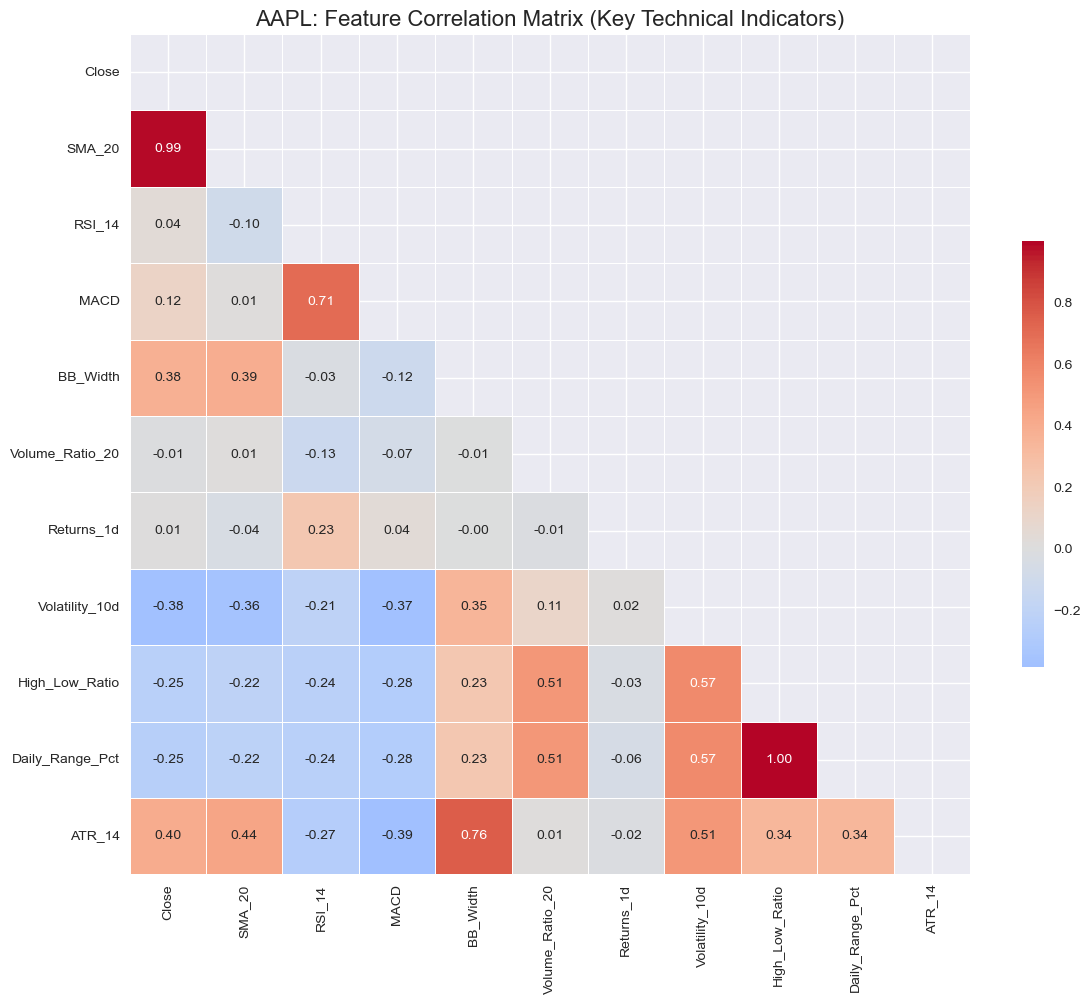


Highly correlated feature pairs (|r| > 0.7):
  • Close ↔ SMA_20: r = 0.988
  • RSI_14 ↔ MACD: r = 0.706
  • BB_Width ↔ ATR_14: r = 0.757
  • High_Low_Ratio ↔ Daily_Range_Pct: r = 0.999


In [11]:
print("Analyzing feature correlations...")

if 'AAPL' in complete_features:
    aapl_features = complete_features['AAPL']
    
    # Select key technical features for correlation analysis
    key_features = [
        'Close', 'SMA_20', 'RSI_14', 'MACD', 'BB_Width',
        'Volume_Ratio_20', 'Returns_1d', 'Volatility_10d',
        'High_Low_Ratio', 'Daily_Range_Pct', 'ATR_14'
    ]
    
    # Filter available features
    available_key_features = [f for f in key_features if f in aapl_features.columns]
    
    if len(available_key_features) > 1:
        # Calculate correlation matrix
        corr_matrix = aapl_features[available_key_features].corr()
        
        # Create correlation heatmap
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": .5}, fmt='.2f')
        plt.title('AAPL: Feature Correlation Matrix (Key Technical Indicators)', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Find highly correlated feature pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:  # High correlation threshold
                    high_corr_pairs.append((
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        corr_val
                    ))
        
        if high_corr_pairs:
            print("\nHighly correlated feature pairs (|r| > 0.7):")
            for feat1, feat2, corr in high_corr_pairs:
                print(f"  • {feat1} ↔ {feat2}: r = {corr:.3f}")
        else:
            print("\nNo highly correlated features detected (|r| > 0.7)")

## 10: Feature Distribution Analysis

Analyzing feature distributions...


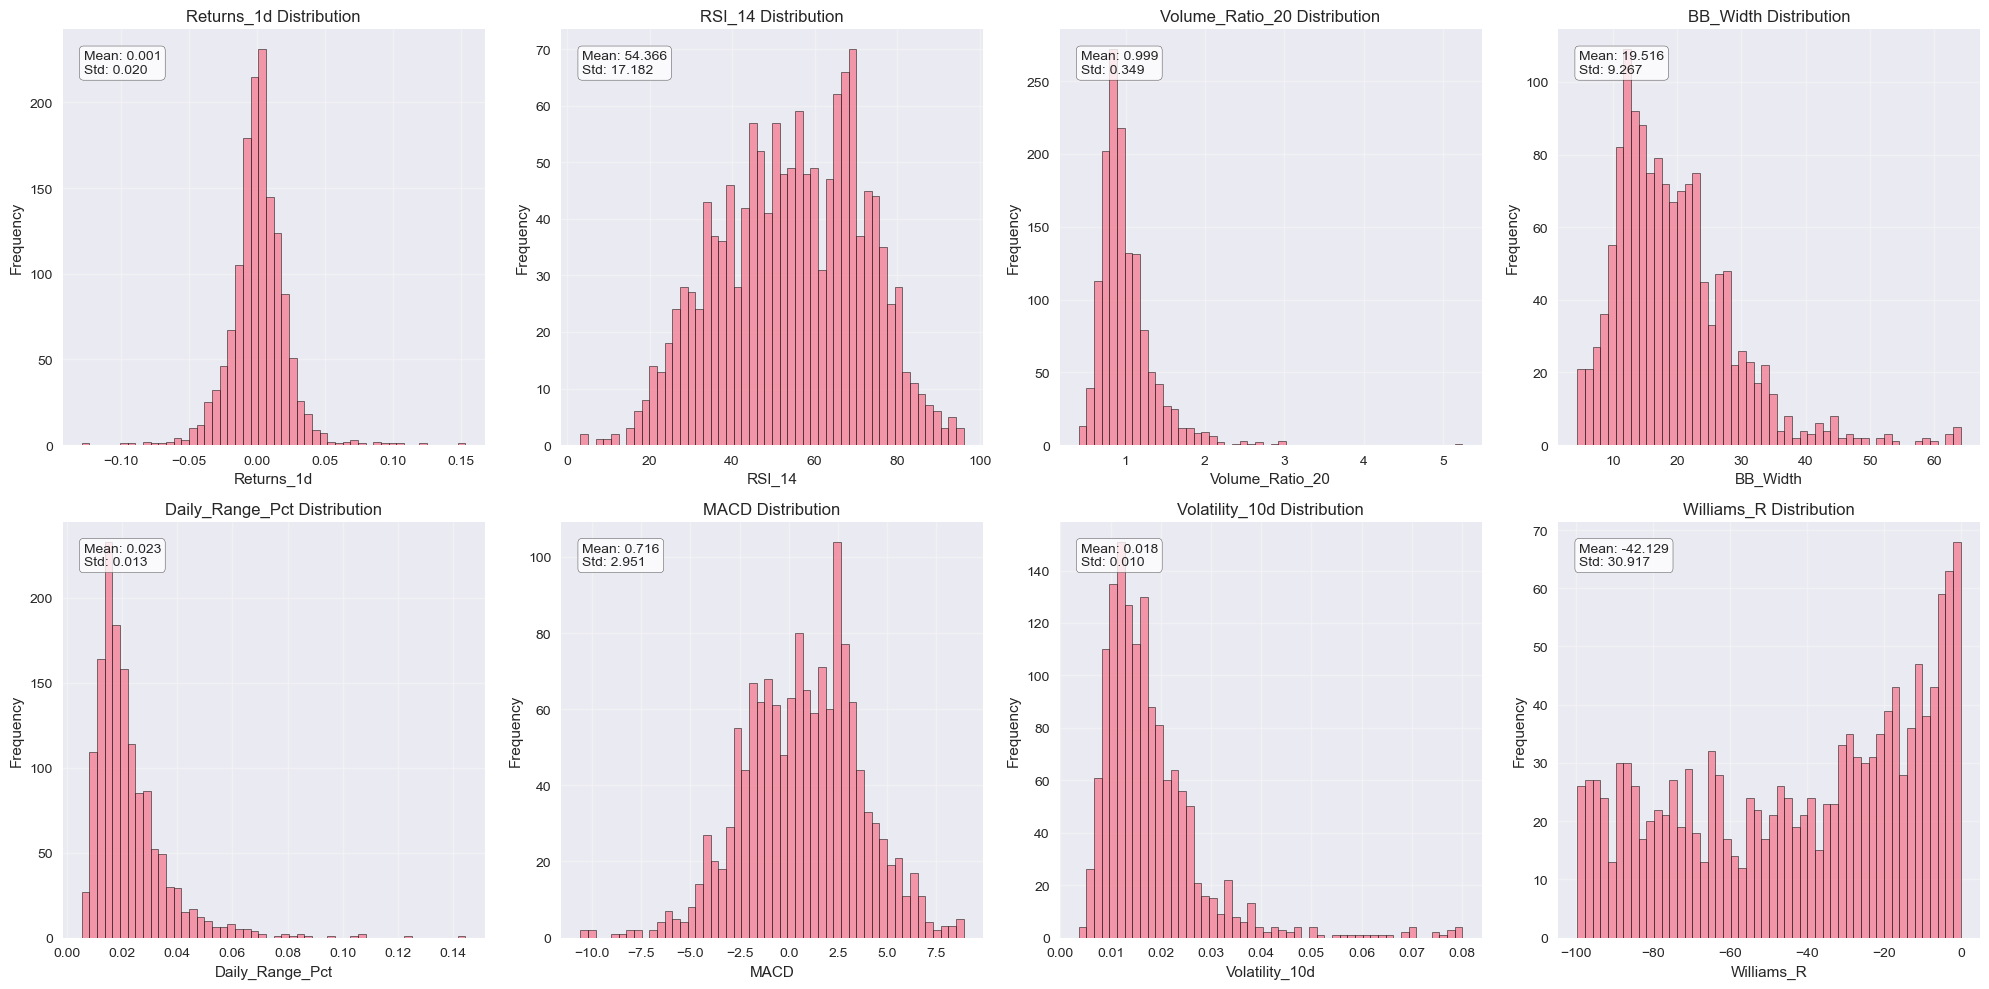


Distribution statistics for 8 features:
  • Returns_1d          : μ=  0.0010, σ=  0.0204, min= -0.1286, max=  0.1533
  • RSI_14              : μ= 54.3656, σ= 17.1822, min=  3.1799, max= 96.1630
  • Volume_Ratio_20     : μ=  0.9994, σ=  0.3487, min=  0.4085, max=  5.2456
  • BB_Width            : μ= 19.5159, σ=  9.2666, min=  4.4490, max= 64.1355
  • Daily_Range_Pct     : μ=  0.0227, σ=  0.0133, min=  0.0054, max=  0.1444
  • MACD                : μ=  0.7163, σ=  2.9507, min=-10.6041, max=  8.9036
  • Volatility_10d      : μ=  0.0179, σ=  0.0103, min=  0.0037, max=  0.0801
  • Williams_R          : μ=-42.1294, σ= 30.9166, min=-99.6493, max= -0.0000


In [12]:
print("Analyzing feature distributions...")

if 'AAPL' in complete_features:
    aapl_features = complete_features['AAPL']
    
    # Select various types of features for distribution analysis
    distribution_features = [
        'Returns_1d', 'RSI_14', 'Volume_Ratio_20', 'BB_Width',
        'Daily_Range_Pct', 'MACD', 'Volatility_10d', 'Williams_R'
    ]
    
    # Filter available features
    available_dist_features = [f for f in distribution_features if f in aapl_features.columns]
    
    if available_dist_features:
        # Create distribution plots
        n_features = len(available_dist_features)
        n_cols = 4
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, feature in enumerate(available_dist_features):
            if i < len(axes):
                # Remove NaN and infinite values for plotting
                feature_data = aapl_features[feature].replace([np.inf, -np.inf], np.nan).dropna()
                
                if len(feature_data) > 0:
                    # Plot histogram
                    axes[i].hist(feature_data, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
                    axes[i].set_title(f'{feature} Distribution', fontsize=12)
                    axes[i].set_xlabel(feature)
                    axes[i].set_ylabel('Frequency')
                    axes[i].grid(True, alpha=0.3)
                    
                    # Add statistics text
                    stats_text = f'Mean: {feature_data.mean():.3f}\nStd: {feature_data.std():.3f}'
                    axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes,
                               verticalalignment='top', 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                else:
                    axes[i].text(0.5, 0.5, f'No valid data\nfor {feature}',
                               transform=axes[i].transAxes, ha='center', va='center')
        
        # Hide unused subplots
        for i in range(len(available_dist_features), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Print distribution statistics
        print(f"\nDistribution statistics for {len(available_dist_features)} features:")
        for feature in available_dist_features:
            feature_data = aapl_features[feature].replace([np.inf, -np.inf], np.nan).dropna()
            if len(feature_data) > 0:
                print(f"  • {feature:20s}: μ={feature_data.mean():8.4f}, "
                     f"σ={feature_data.std():8.4f}, "
                     f"min={feature_data.min():8.4f}, max={feature_data.max():8.4f}")


## 11: Missing Values Analysis

Analyzing missing values...


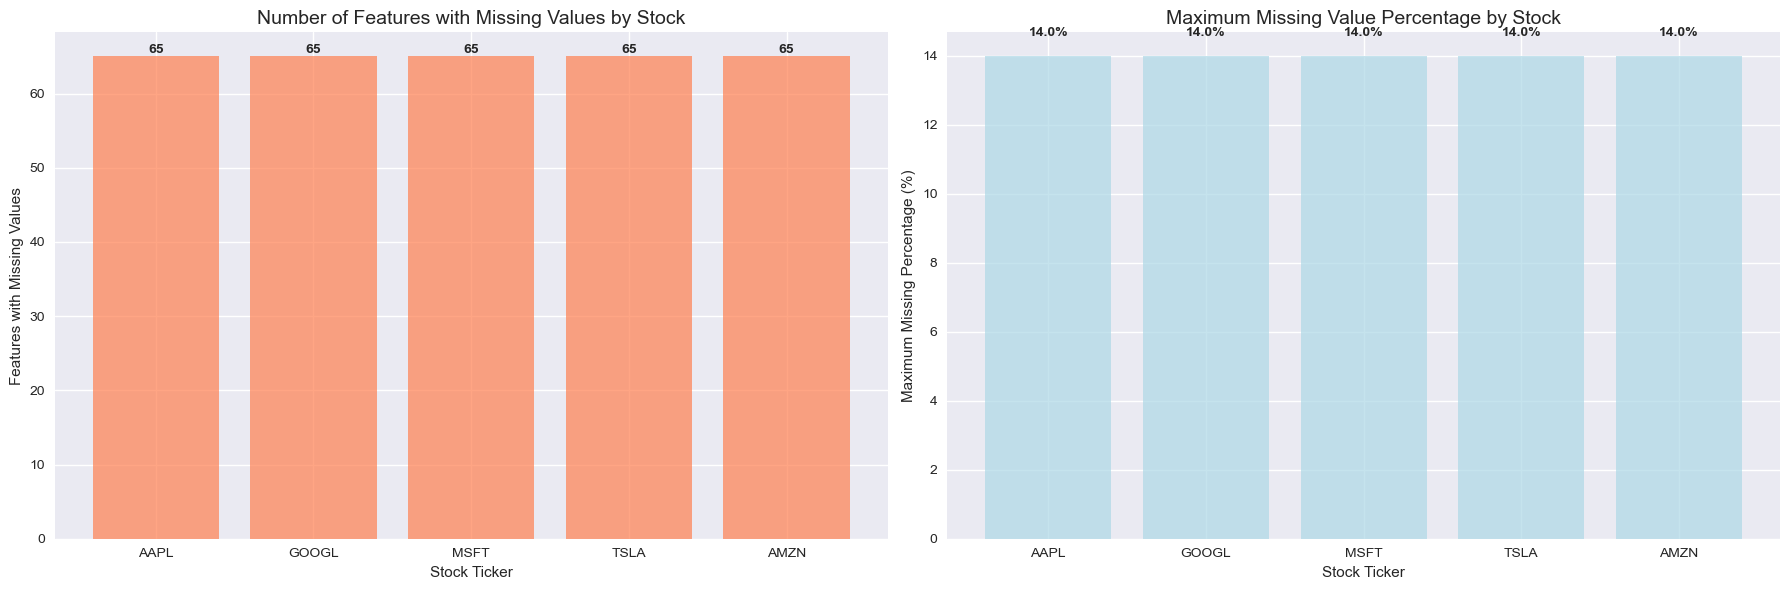


Missing values summary:

AAPL:
  • Total features: 83
  • Features with missing values: 65
  • Maximum missing percentage: 13.98%
  • Top missing features: {'SMA_200': 13.984539704848912, 'SMA_50': 3.4434293745607873, 'Volatility_30d': 2.1082220660576247, 'Log_Returns_20d': 1.4054813773717498, 'Returns_20d': 1.4054813773717498}

GOOGL:
  • Total features: 83
  • Features with missing values: 65
  • Maximum missing percentage: 13.98%
  • Top missing features: {'SMA_200': 13.984539704848912, 'SMA_50': 3.4434293745607873, 'Volatility_30d': 2.1082220660576247, 'Log_Returns_20d': 1.4054813773717498, 'Returns_20d': 1.4054813773717498}

MSFT:
  • Total features: 83
  • Features with missing values: 65
  • Maximum missing percentage: 13.98%
  • Top missing features: {'SMA_200': 13.984539704848912, 'SMA_50': 3.4434293745607873, 'Volatility_30d': 2.1082220660576247, 'Log_Returns_20d': 1.4054813773717498, 'Returns_20d': 1.4054813773717498}

TSLA:
  • Total features: 83
  • Features with missing 

In [13]:
print("Analyzing missing values...")

# Analyze missing values across all stocks
missing_analysis = {}

for ticker, features_df in complete_features.items():
    # Calculate missing value percentages
    missing_pct = (features_df.isnull().sum() / len(features_df)) * 100
    missing_features = missing_pct[missing_pct > 0].sort_values(ascending=False)
    
    missing_analysis[ticker] = {
        'total_features': len(features_df.columns),
        'features_with_missing': len(missing_features),
        'max_missing_pct': missing_features.iloc[0] if len(missing_features) > 0 else 0,
        'missing_details': missing_features.to_dict()
    }

# Create missing values visualization
if missing_analysis:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Missing values by stock
    stocks = list(missing_analysis.keys())
    missing_counts = [missing_analysis[stock]['features_with_missing'] for stock in stocks]
    max_missing = [missing_analysis[stock]['max_missing_pct'] for stock in stocks]
    
    ax1 = axes[0]
    bars = ax1.bar(stocks, missing_counts, alpha=0.7, color='coral')
    ax1.set_title('Number of Features with Missing Values by Stock', fontsize=14)
    ax1.set_ylabel('Features with Missing Values')
    ax1.set_xlabel('Stock Ticker')
    
    # Add value labels on bars
    for bar, count in zip(bars, missing_counts):
        if count > 0:
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                    f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Maximum missing percentage by stock
    ax2 = axes[1]
    bars2 = ax2.bar(stocks, max_missing, alpha=0.7, color='lightblue')
    ax2.set_title('Maximum Missing Value Percentage by Stock', fontsize=14)
    ax2.set_ylabel('Maximum Missing Percentage (%)')
    ax2.set_xlabel('Stock Ticker')
    
    # Add percentage labels
    for bar, pct in zip(bars2, max_missing):
        if pct > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Print detailed missing values report
print(f"\nMissing values summary:")
for ticker, analysis in missing_analysis.items():
    print(f"\n{ticker}:")
    print(f"  • Total features: {analysis['total_features']}")
    print(f"  • Features with missing values: {analysis['features_with_missing']}")
    if analysis['features_with_missing'] > 0:
        print(f"  • Maximum missing percentage: {analysis['max_missing_pct']:.2f}%")
        # Show top 5 features with most missing values
        top_missing = dict(list(analysis['missing_details'].items())[:5])
        print(f"  • Top missing features: {top_missing}")

## 12: Export Features and Create Summary

In [14]:
print("Exporting features and creating summary...")

# Create output directory for processed features
os.makedirs('../data/processed', exist_ok=True)

# Export feature datasets
export_summary = {}

for ticker, features_df in complete_features.items():
    # Clean the dataset (remove infinite values)
    clean_features = features_df.replace([np.inf, -np.inf], np.nan)
    
    # Export to CSV
    output_path = f'../data/processed/{ticker}_features.csv'
    clean_features.to_csv(output_path)
    
    export_summary[ticker] = {
        'output_file': output_path,
        'total_features': len(clean_features.columns),
        'total_rows': len(clean_features),
        'date_range': f"{clean_features.index.min().date()} to {clean_features.index.max().date()}"
    }
    
    print(f"✓ {ticker}: Features exported to {output_path}")

# Create master summary report
summary_report = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'stocks_processed': list(complete_features.keys()),
    'total_stocks': len(complete_features),
    'feature_engineering_steps': [
        'Technical indicators (SMA, EMA, RSI, MACD, Bollinger Bands, etc.)',
        'Price features (ratios, ranges, gaps)',
        'Volume features (ratios, moving averages)',
        'Return features (simple, log returns, volatility)',
        'Lag features (1, 2, 3, 5 periods)',
        'Rolling window features (5, 10, 20 periods)'
    ],
    'export_summary': export_summary,
    'validation_reports': validation_reports
}

# Export summary report
with open('../data/processed/feature_engineering_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print(f"\nFeature Engineering Summary:")
print(f"  • Stocks processed: {summary_report['total_stocks']}")
print(f"  • Feature engineering steps: {len(summary_report['feature_engineering_steps'])}")
print(f"  • Output files created: {len(export_summary)}")
print(f"  • Summary report: ../data/processed/feature_engineering_summary.json")

print("\nFeature engineering notebook completed successfully!")

Exporting features and creating summary...
✓ AAPL: Features exported to ../data/processed/AAPL_features.csv
✓ GOOGL: Features exported to ../data/processed/GOOGL_features.csv
✓ MSFT: Features exported to ../data/processed/MSFT_features.csv
✓ TSLA: Features exported to ../data/processed/TSLA_features.csv
✓ AMZN: Features exported to ../data/processed/AMZN_features.csv

Feature Engineering Summary:
  • Stocks processed: 5
  • Feature engineering steps: 6
  • Output files created: 5
  • Summary report: ../data/processed/feature_engineering_summary.json

Feature engineering notebook completed successfully!
